In [35]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import NAdam
from torch.autograd import Variable
import torchvision
import pathlib

In [36]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
print(device)

cuda


In [38]:
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [39]:
train_path= r'C:\Users\DAWN\Documents\Python Scripts\python\data\train'
test_path= r'C:\Users\DAWN\Documents\Python Scripts\python\data\test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [40]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [41]:
print(classes)

['benign', 'malignant']


In [42]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.Softmax()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.Softmax()
        #Shape= (256,20,75,75)
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.Softmax()
        #Shape= (256,32,75,75)
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
        output=self.fc(output)            
        return output

In [43]:
model=ConvNet(num_classes=2).to(device)

In [10]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [46]:
num_epochs=100

In [47]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)

2637 660


In [48]:
ta = [0]*100
tl = [0]*100
tea = [0]*100
tel = [0]*100

In [19]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    test_accuracy=0.0
    test_loss=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        test_loss+= loss.cpu().data*images.size(0)  
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss=test_loss/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    ta[epoch] = train_accuracy
    tl[epoch] = train_loss
    tea[epoch] = test_accuracy
    tel[epoch] = test_loss
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_softmax.model')
        best_accuracy=test_accuracy

C:\Users\DAWN\AppData\Local\Temp/ipykernel_19376/1055844645.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output=self.relu1(output)
C:\Users\DAWN\AppData\Local\Temp/ipykernel_19376/1055844645.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output=self.relu2(output)
C:\Users\DAWN\AppData\Local\Temp/ipykernel_19376/1055844645.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output=self.relu3(output)


Epoch: 0 Train Loss: tensor(0.0019) Train Accuracy: 1.0 Test Accuracy: 0.8151515151515152
Epoch: 1 Train Loss: tensor(0.0021) Train Accuracy: 1.0 Test Accuracy: 0.8287878787878787
Epoch: 2 Train Loss: tensor(0.0017) Train Accuracy: 1.0 Test Accuracy: 0.8318181818181818
Epoch: 3 Train Loss: tensor(0.0017) Train Accuracy: 1.0 Test Accuracy: 0.8272727272727273
Epoch: 4 Train Loss: tensor(0.0017) Train Accuracy: 1.0 Test Accuracy: 0.8242424242424242
Epoch: 5 Train Loss: tensor(0.0017) Train Accuracy: 1.0 Test Accuracy: 0.8378787878787879
Epoch: 6 Train Loss: tensor(0.0019) Train Accuracy: 1.0 Test Accuracy: 0.8181818181818182
Epoch: 7 Train Loss: tensor(0.0016) Train Accuracy: 1.0 Test Accuracy: 0.8257575757575758
Epoch: 8 Train Loss: tensor(0.0018) Train Accuracy: 1.0 Test Accuracy: 0.8257575757575758
Epoch: 9 Train Loss: tensor(0.0018) Train Accuracy: 1.0 Test Accuracy: 0.8333333333333334
Epoch: 10 Train Loss: tensor(0.0018) Train Accuracy: 1.0 Test Accuracy: 0.8378787878787879
Epoch: 11

Epoch: 89 Train Loss: tensor(0.0008) Train Accuracy: 1.0 Test Accuracy: 0.8303030303030303
Epoch: 90 Train Loss: tensor(0.0008) Train Accuracy: 1.0 Test Accuracy: 0.8181818181818182
Epoch: 91 Train Loss: tensor(0.0022) Train Accuracy: 1.0 Test Accuracy: 0.8287878787878787
Epoch: 92 Train Loss: tensor(0.0011) Train Accuracy: 1.0 Test Accuracy: 0.8303030303030303
Epoch: 93 Train Loss: tensor(0.0009) Train Accuracy: 1.0 Test Accuracy: 0.8272727272727273
Epoch: 94 Train Loss: tensor(0.0009) Train Accuracy: 1.0 Test Accuracy: 0.8348484848484848
Epoch: 95 Train Loss: tensor(0.0008) Train Accuracy: 1.0 Test Accuracy: 0.8409090909090909
Epoch: 96 Train Loss: tensor(0.0012) Train Accuracy: 1.0 Test Accuracy: 0.8303030303030303
Epoch: 97 Train Loss: tensor(0.0009) Train Accuracy: 1.0 Test Accuracy: 0.8257575757575758
Epoch: 98 Train Loss: tensor(0.0009) Train Accuracy: 1.0 Test Accuracy: 0.8378787878787879
Epoch: 99 Train Loss: tensor(0.0010) Train Accuracy: 1.0 Test Accuracy: 0.8318181818181818

In [20]:
import torchinfo
torchinfo.summary(model, (3, 150, 150), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 
                                                                    'kernel_size', 'mult_adds'), verbose = 0)

C:\Users\DAWN\AppData\Local\Temp/ipykernel_19376/1055844645.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output=self.relu1(output)
C:\Users\DAWN\AppData\Local\Temp/ipykernel_19376/1055844645.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output=self.relu2(output)
C:\Users\DAWN\AppData\Local\Temp/ipykernel_19376/1055844645.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output=self.relu3(output)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ConvNet                                  [1, 3, 150, 150]          [1, 2]                    --                        --                        --
├─Conv2d: 1-1                            [1, 3, 150, 150]          [1, 12, 150, 150]         336                       [3, 3]                    7,560,000
├─BatchNorm2d: 1-2                       [1, 12, 150, 150]         [1, 12, 150, 150]         24                        --                        24
├─Softmax: 1-3                           [1, 12, 150, 150]         [1, 12, 150, 150]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 12, 150, 150]         [1, 12, 75, 75]           --                        2                         --
├─Conv2d: 1-5                            [1, 12, 75, 75]           [1, 20, 75, 75]           2,180

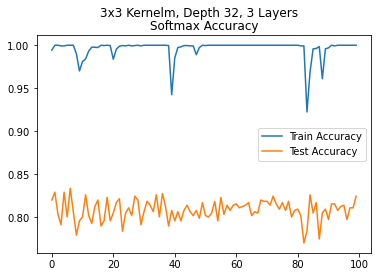

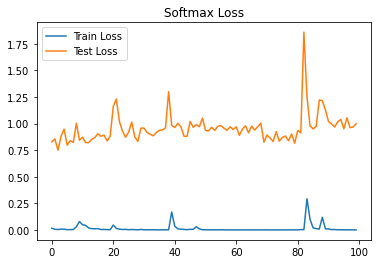

In [76]:
plt.suptitle('3x3 Kernelm, Depth 32, 3 Layers')
plt.title('Softmax Accuracy')
plt.plot(ta)
plt.plot(tea)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

plt.title('Softmax Loss')
plt.plot(tl)
plt.plot(tel)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

In [23]:
a = [0]*100
l = [0]*100
for i in range(0,100):
    a[i] = ta[i] - tea[i]
    l[i] = tel[i] - tl[i]
sa=0
sl=0
for i in range(0,100):
    sa = sa + a[i]
    sl = sl + l[i]

In [32]:
#Avg Difference in Accuracy
sa/100

0.1726388457958424

In [25]:
#Avg Difference in Loss
sl/100

tensor(0.7694)

In [26]:
sa1=0
sa2=0
sl1=0
sl2 = 0
for i in range(0,100):
    sa1 = sa1+ta[i]
    sl1 = sl1+tl[i]
    sa2 = sa2+tea[i]
    sl2 = sl2+tel[i]

In [31]:
sl1/100

tensor(0.0051)

In [44]:
# changing filter size and depth

In [61]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=5,stride=1,padding=2)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.Softmax()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=5,stride=1,padding=2)
        #Shape= (256,20,75,75)
        self.relu2=nn.Softmax()
        #Shape= (256,20,75,75)
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=5,stride=1,padding=2)
        #Shape= (256,20,75,75)
        self.relu23=nn.Softmax()
        #Shape= (256,20,75,75)
        
        self.conv4=nn.Conv2d(in_channels=32,out_channels=48,kernel_size=5,stride=1,padding=2)
        #Shape= (256,32,75,75)
        self.bn4=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu4=nn.Softmax()
        #Shape= (256,32,75,75)
        
        self.fc=nn.Linear(in_features=75 * 75 * 48,out_features=num_classes)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
        
        output=self.conv3(output)
        output=self.relu3(output)
            
        output=self.conv4(output)
        output=self.bn4(output)
        output=self.relu4(output)
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,48*75*75)
        output=self.fc(output)            
        return output

In [62]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [64]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    test_accuracy=0.0
    test_loss=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        test_loss+= loss.cpu().data*images.size(0)  
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss=test_loss/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    ta[epoch] = train_accuracy
    tl[epoch] = train_loss
    tea[epoch] = test_accuracy
    tel[epoch] = test_loss
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_softmax_48ch.pth')
        best_accuracy=test_accuracy

C:\Users\DAWN\AppData\Local\Temp/ipykernel_19376/1055844645.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output=self.relu1(output)
C:\Users\DAWN\AppData\Local\Temp/ipykernel_19376/1055844645.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output=self.relu2(output)
C:\Users\DAWN\AppData\Local\Temp/ipykernel_19376/1055844645.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output=self.relu3(output)


Epoch: 0 Train Loss: tensor(0.0169) Train Accuracy: 0.9943117178612059 Test Accuracy: 0.8196969696969697
Epoch: 1 Train Loss: tensor(0.0065) Train Accuracy: 1.0 Test Accuracy: 0.8287878787878787
Epoch: 2 Train Loss: tensor(0.0046) Train Accuracy: 1.0 Test Accuracy: 0.803030303030303
Epoch: 3 Train Loss: tensor(0.0078) Train Accuracy: 0.9992415623814941 Test Accuracy: 0.7909090909090909
Epoch: 4 Train Loss: tensor(0.0077) Train Accuracy: 0.9992415623814941 Test Accuracy: 0.8287878787878787
Epoch: 5 Train Loss: tensor(0.0034) Train Accuracy: 1.0 Test Accuracy: 0.8
Epoch: 6 Train Loss: tensor(0.0036) Train Accuracy: 1.0 Test Accuracy: 0.8333333333333334
Epoch: 7 Train Loss: tensor(0.0039) Train Accuracy: 1.0 Test Accuracy: 0.806060606060606
Epoch: 8 Train Loss: tensor(0.0306) Train Accuracy: 0.9901403109594236 Test Accuracy: 0.7787878787878788
Epoch: 9 Train Loss: tensor(0.0795) Train Accuracy: 0.9700417140690178 Test Accuracy: 0.7954545454545454
Epoch: 10 Train Loss: tensor(0.0493) Train

Epoch: 86 Train Loss: tensor(0.0130) Train Accuracy: 0.9962078119074707 Test Accuracy: 0.8166666666666667
Epoch: 87 Train Loss: tensor(0.0086) Train Accuracy: 0.9984831247629883 Test Accuracy: 0.7742424242424243
Epoch: 88 Train Loss: tensor(0.1193) Train Accuracy: 0.9609404626469473 Test Accuracy: 0.8045454545454546
Epoch: 89 Train Loss: tensor(0.0105) Train Accuracy: 0.9958285930982177 Test Accuracy: 0.8090909090909091
Epoch: 90 Train Loss: tensor(0.0103) Train Accuracy: 0.9969662495259765 Test Accuracy: 0.796969696969697
Epoch: 91 Train Loss: tensor(0.0034) Train Accuracy: 1.0 Test Accuracy: 0.8151515151515152
Epoch: 92 Train Loss: tensor(0.0047) Train Accuracy: 0.9992415623814941 Test Accuracy: 0.8151515151515152
Epoch: 93 Train Loss: tensor(0.0016) Train Accuracy: 1.0 Test Accuracy: 0.8075757575757576
Epoch: 94 Train Loss: tensor(0.0020) Train Accuracy: 1.0 Test Accuracy: 0.8121212121212121
Epoch: 95 Train Loss: tensor(0.0017) Train Accuracy: 1.0 Test Accuracy: 0.8136363636363636
E

In [65]:
a = [0]*100
l = [0]*100
for i in range(0,100):
    a[i] = ta[i] - tea[i]
    l[i] = tel[i] - tl[i]
sa=0
sl=0
for i in range(0,100):
    sa = sa + a[i]
    sl = sl + l[i]

In [66]:
#Avg Difference in Accuracy
sa/100

0.18816232288757884

In [67]:
#Avg Difference in Loss
sl/100

tensor(0.9407)

In [79]:
sa1=0
sa2=0
sl1=0
sl2 = 0
for i in range(0,100):
    sa1 = sa1+ta[i]
    sl1 = sl1+tl[i]
    sa2 = sa2+tea[i]
    sl2 = sl2+tel[i]

In [80]:
sa1

99.61774744027305

In [70]:
sa2

80.80151515151515

In [71]:
sl1/100

tensor(0.0136)

In [72]:
sl2/100

tensor(0.9543)

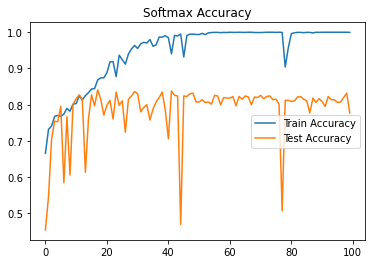

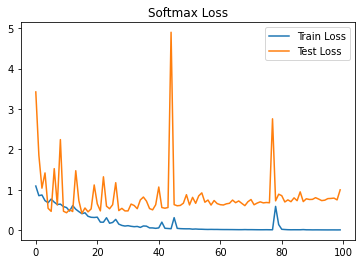

In [60]:
# 3x3 kernel, 32 channels, 3 layers
plt.title('Softmax Accuracy')
plt.plot(ta)
plt.plot(tea)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

plt.title('Softmax Loss')
plt.plot(tl)
plt.plot(tel)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

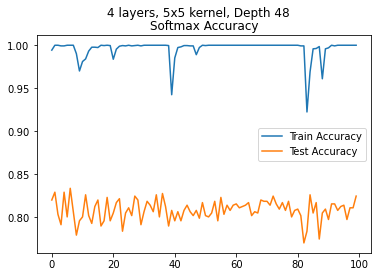

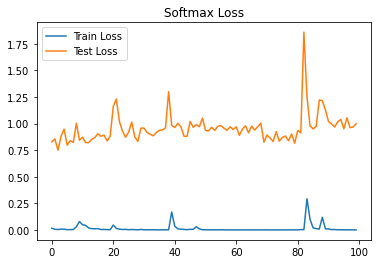

In [77]:
plt.suptitle('4 layers, 5x5 kernel, Depth 48')
plt.title('Softmax Accuracy')
plt.plot(ta)
plt.plot(tea)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

plt.title('Softmax Loss')
plt.plot(tl)
plt.plot(tel)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()